<a href="https://colab.research.google.com/github/HwangJae-won/Data_project_practice/blob/main/1005_titanic_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 기본 설정

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 무시하기
import warnings
warnings.filterwarnings(action='ignore')

In [239]:
df = sns.load_dataset('titanic')
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


# EDA

In [197]:
#데이터 기본 정보 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


몇몇 변수에서 결측치를 확인할 수 있다. target 변수는 "survived"

In [198]:
df.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<Axes: xlabel='age', ylabel='Count'>

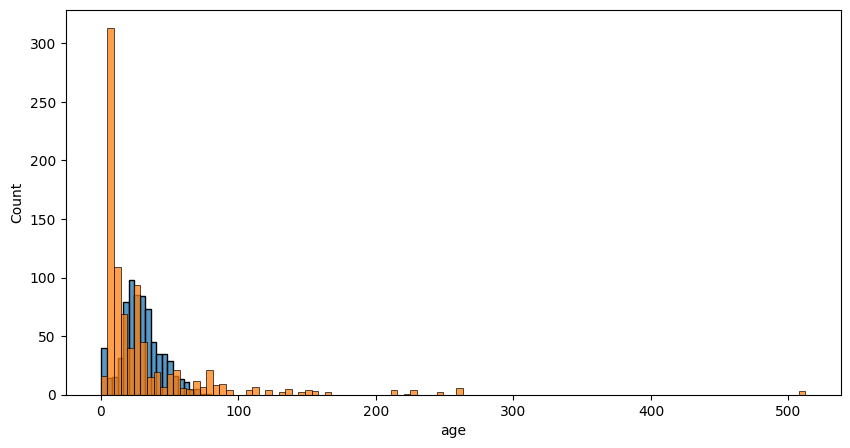

In [199]:
#age와 fare에 대해서 plot으로 분포 확인하기
plt.figure(figsize=(10,5))
sns.histplot(df["age"])
sns.histplot(df["fare"])

- skewed함을 보이고 있으므로 연속형 변수에 대해 스케일링 필요함

target 변수와의 연관성 확인

<Axes: >

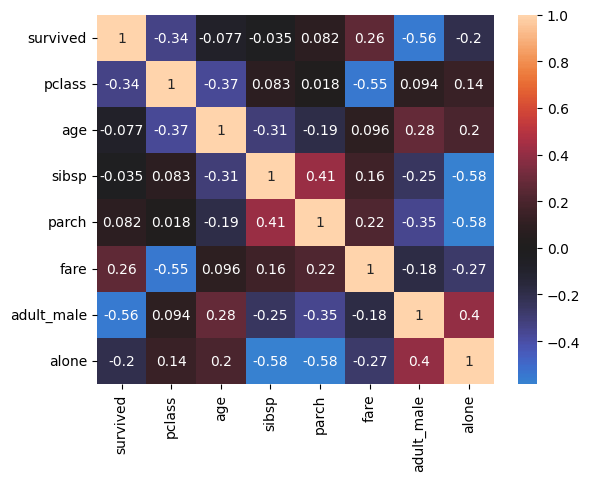

In [200]:
corr = df.corr()
sns.heatmap(corr, annot = True, center =0) #상관계수 동시에 확인, 중앙값 0으로 설정

In [201]:
corr["survived"].sort_values(ascending = True)

adult_male   -0.557080
pclass       -0.338481
alone        -0.203367
age          -0.077221
sibsp        -0.035322
parch         0.081629
fare          0.257307
survived      1.000000
Name: survived, dtype: float64

adult_male , pclass가 가장 높은 연관성을 보이고 있음: 더미 변수 생성해서 활용하기

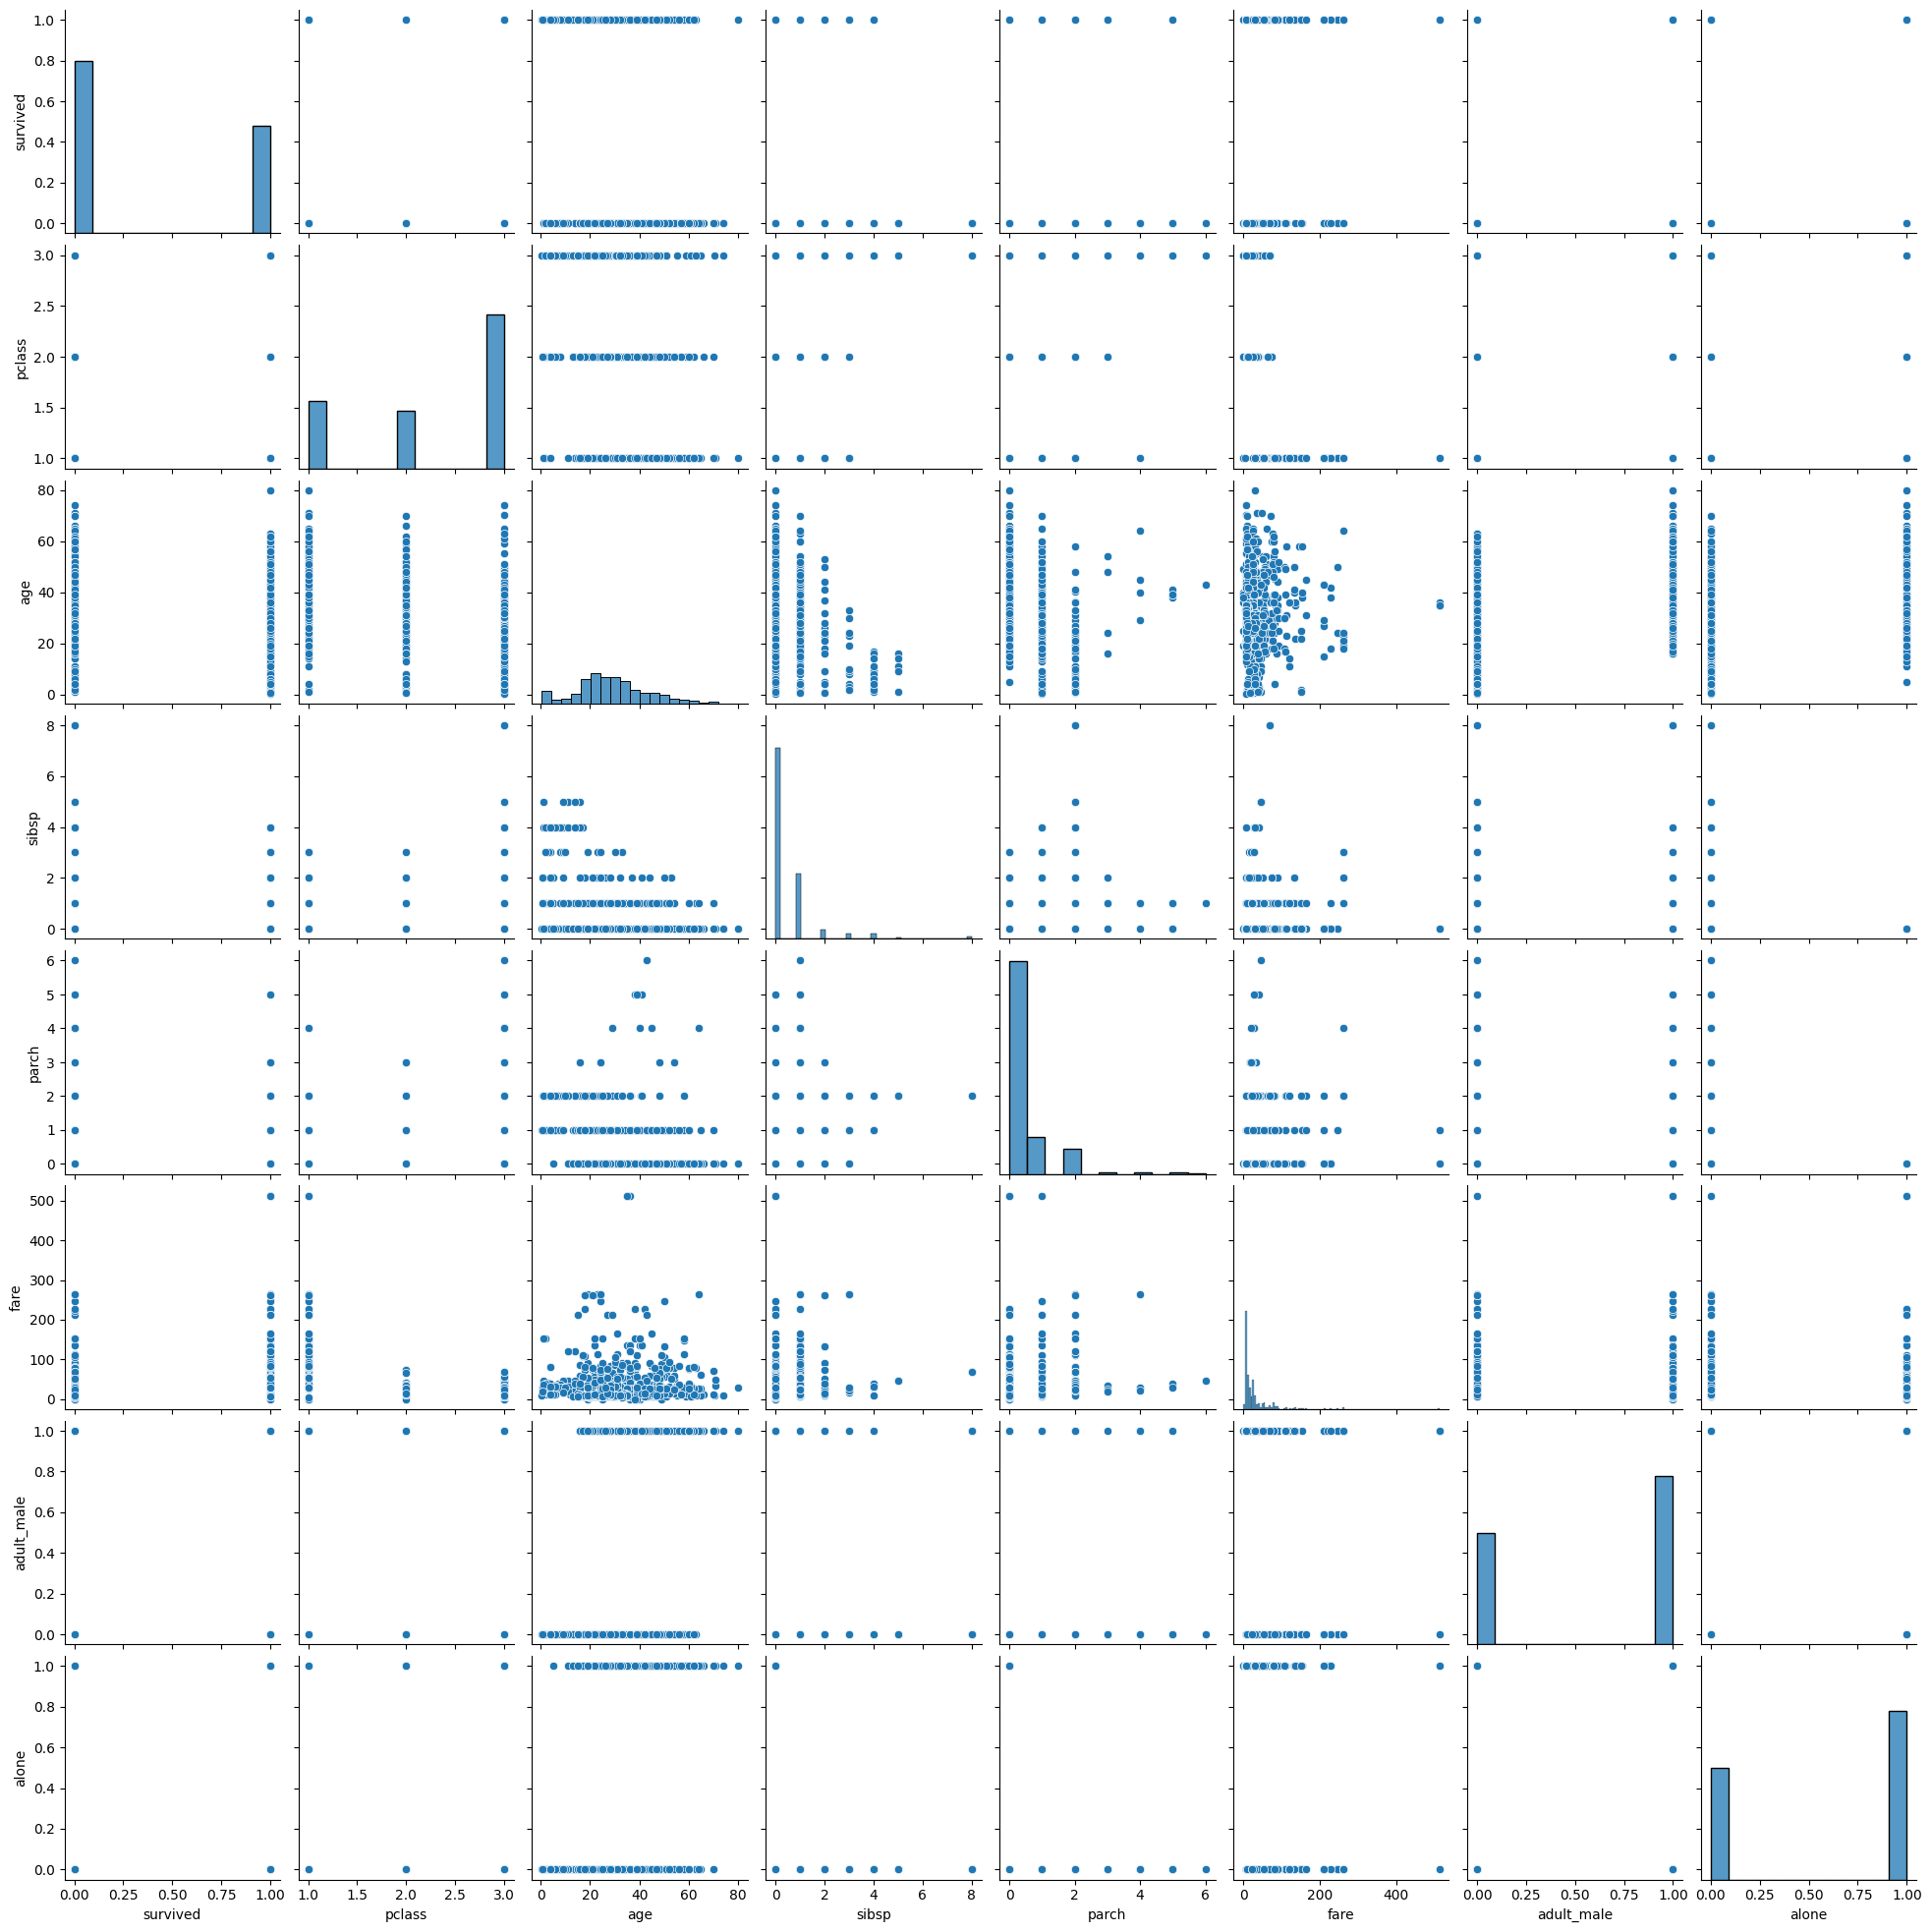

In [202]:
sns.pairplot(df)

변수들 간 선형 관계를 보이는 케이스가 없으므로 다중공선성은 고려하지 않아도 됨.

In [203]:
# 타겟 설정 -생존 여부
target = 'survived'

# 타겟의 분포 확인
df[target].value_counts(normalize = True)

0    0.616162
1    0.383838
Name: survived, dtype: float64

<Axes: xlabel='survived', ylabel='count'>

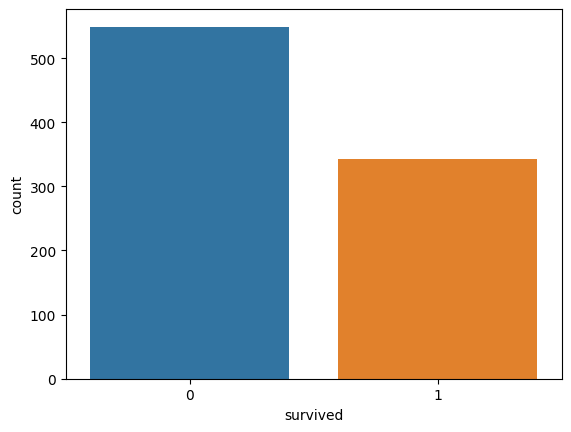

In [204]:
sns.countplot(x= target, data= df)

약간의 불균형이 있지만 6:4 정도기 때문에 따로 불균형 처리는 수행하지 않음

# 결측치 처리
몇몇의 결측치가 보임. 해당 변수 처리 필요, 우선 categorical 변수 처리 수행

In [206]:
#결측치 개수 확인
df.isnull().sum().sort_values(ascending=False)/len(df)*100

deck           77.216611
age            19.865320
embarked        0.224467
embark_town     0.224467
survived        0.000000
pclass          0.000000
sex             0.000000
sibsp           0.000000
parch           0.000000
fare            0.000000
class           0.000000
who             0.000000
adult_male      0.000000
alive           0.000000
alone           0.000000
dtype: float64

deck, age, embarked, embark_town에 결측치가 있음

<Axes: >

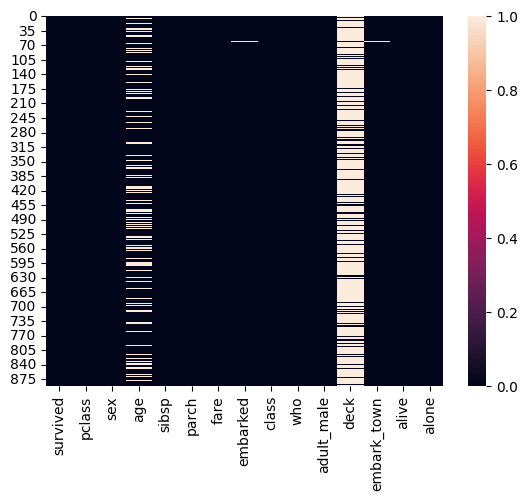

In [9]:
#결측치 시각적으로 확인
sns.heatmap(df.isnull())

- deck는 결측치가 70%이므로 단순 제거 고려할 수 있지만, Unkown으로 채우거나 다른 변수와의 연관성 파악을 통해 채울 수 있음
- 결측치 여부를 나타내는 변수를 새로 추기

<Axes: xlabel='deck', ylabel='count'>

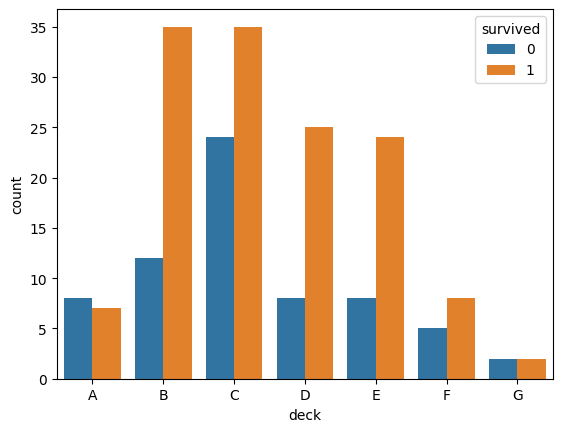

In [10]:
sns.countplot(x = 'deck', hue = 'survived', data = df)

생존자 별 deck의 위치 차이가 많이 남. 단순 제거 시 성능이 저하될 것으로 생각됨
=> 결측치 여부를 구분하는 변수를 추가하고, unknown으로 채우기

In [212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 889
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   survived        891 non-null    object
 1   pclass          891 non-null    object
 2   sex             891 non-null    object
 3   age             714 non-null    object
 4   sibsp           891 non-null    object
 5   parch           891 non-null    object
 6   fare            891 non-null    object
 7   embarked        889 non-null    object
 8   class           891 non-null    object
 9   who             891 non-null    object
 10  adult_male      891 non-null    object
 11  deck            891 non-null    object
 12  embark_town     889 non-null    object
 13  alive           891 non-null    object
 14  alone           891 non-null    object
 15  deck_isnotnull  891 non-null    object
dtypes: object(16)
memory usage: 118.3+ KB


In [240]:
#결측치 있는 데이터만 추출 후 결측치여부 나타내는 변수(deck_isnotnull)에 1부여
df_null = df[df.deck.isnull()]
df_null["deck_isnotnull"] = 1
df_null

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,deck_isnotnull
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False,1
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True,1
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True,1
5,0,3,male,NaN,0,0,8.4583,Q,Third,man,True,NaN,Queenstown,no,True,1
7,0,3,male,2.0,3,1,21.0750,S,Third,child,False,NaN,Southampton,no,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,0,3,male,25.0,0,0,7.0500,S,Third,man,True,NaN,Southampton,no,True,1
885,0,3,female,39.0,0,5,29.1250,Q,Third,woman,False,NaN,Queenstown,no,False,1
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True,1
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False,1


In [241]:
#결측치를 채우기 위해 데이터 타입을 category에서 object로 변경 후 unknown으로 채우기
df_null =df_null.astype({"deck":"object"})
df_null["deck"] = df_null["deck"].fillna('Unkown')

In [242]:
#결측치 없는 데이터 추출 후 결측치여부 나타내는 변수(deck_isnotnull)에 0부여
df_notnull = df[df.deck.notnull()]
df_notnull["deck_isnotnull"] = 0

In [243]:
#두 데이터 합치기
df = pd.concat([df_null, df_notnull], axis= 0)

In [244]:
#데이터 확인: 새로운 변수 잘 추가되었음, 결측치가 unknown으로 잘 채워짐
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,deck_isnotnull
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,Unkown,Southampton,no,False,1
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,Unkown,Southampton,yes,True,1
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,Unkown,Southampton,no,True,1
5,0,3,male,NaN,0,0,8.4583,Q,Third,man,True,Unkown,Queenstown,no,True,1
7,0,3,male,2.0,3,1,21.0750,S,Third,child,False,Unkown,Southampton,no,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
871,1,1,female,47.0,1,1,52.5542,S,First,woman,False,D,Southampton,yes,False,0
872,0,1,male,33.0,0,0,5.0000,S,First,man,True,B,Southampton,no,True,0
879,1,1,female,56.0,0,1,83.1583,C,First,woman,False,C,Cherbourg,yes,False,0
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True,0


<Axes: xlabel='deck', ylabel='count'>

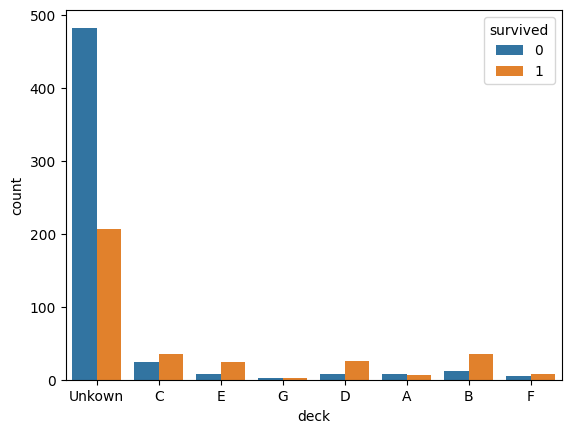

In [15]:
sns.countplot(x = 'deck', hue = 'survived', data = df)

unknown(원래 결측치)를 보았을 때도 생존 여부가 많이 차이남. 단순 제거했으면 성능이 많이 저하됐을 것으로 예상됨. unknown 활용

In [51]:
df.isnull().sum()
#아직 3개의 변수에 결측치 존재

survived            0
pclass              0
sex                 0
age               177
sibsp               0
parch               0
fare                0
embarked            2
class               0
who                 0
adult_male          0
deck                0
embark_town         2
alive               0
alone               0
deck_isnotnull      0
dtype: int64

<Axes: xlabel='age', ylabel='Count'>

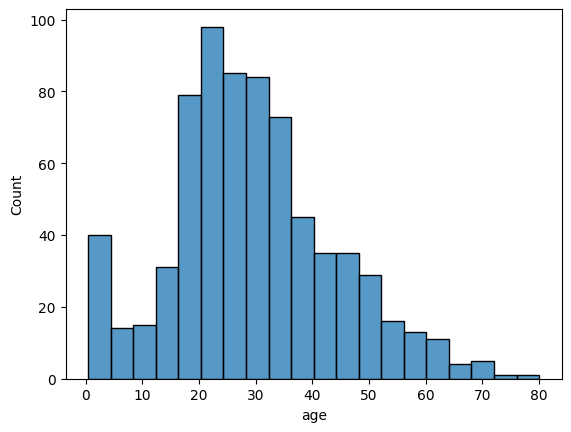

In [52]:
#age 변수의 분포 확인: 튀는 값이 있긴하지만 전체적으로 normal distribution
sns.histplot(df.age)

In [245]:
#mean으로 채우기
df['age'] = df['age'].fillna(df.age.mean())

In [226]:
#채워졌는지 확인
df.isnull().sum()

survived          0
pclass            0
sex               0
age               0
sibsp             0
parch             0
fare              0
embarked          2
class             0
who               0
adult_male        0
deck              0
embark_town       2
alive             0
alone             0
deck_isnotnull    0
dtype: int64

<Axes: xlabel='embark_town', ylabel='count'>

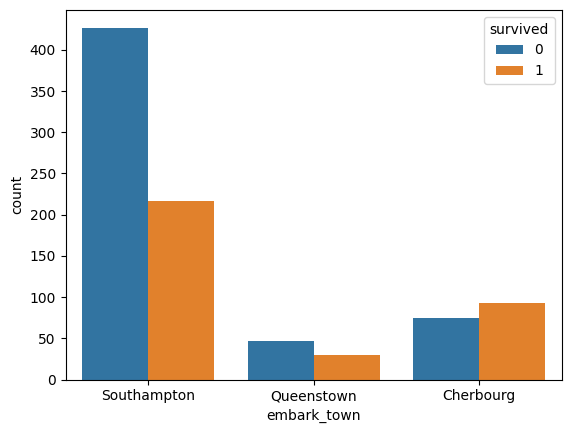

In [22]:
sns.countplot(x = "embark_town", hue = 'survived', data = df)

<Axes: xlabel='embarked', ylabel='count'>

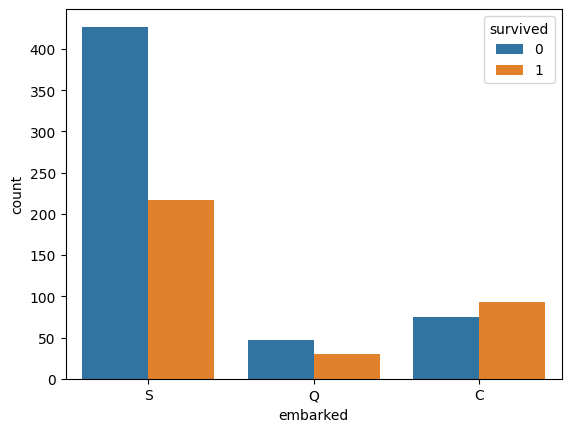

In [23]:
sns.countplot(x = "embarked", hue = 'survived', data = df)

Southampton, S가 많은 부분 차지 -> 결측치가 2개밖에 없으므로 최빈값으로 대체

In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 889
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   survived        891 non-null    object 
 1   pclass          891 non-null    object 
 2   sex             891 non-null    object 
 3   age             891 non-null    float64
 4   sibsp           891 non-null    object 
 5   parch           891 non-null    object 
 6   fare            891 non-null    object 
 7   embarked        889 non-null    object 
 8   class           891 non-null    object 
 9   who             891 non-null    object 
 10  adult_male      891 non-null    object 
 11  deck            891 non-null    object 
 12  embark_town     889 non-null    object 
 13  alive           891 non-null    object 
 14  alone           891 non-null    object 
 15  deck_isnotnull  891 non-null    object 
dtypes: float64(1), object(15)
memory usage: 118.3+ KB


In [246]:
df["embark_town"] = df["embark_town"].fillna(df['embark_town'].mode()[0])
df["embarked"] =df["embarked"].fillna(df['embarked'].mode()[0])

In [228]:
df.isnull().sum()

survived          0
pclass            0
sex               0
age               0
sibsp             0
parch             0
fare              0
embarked          0
class             0
who               0
adult_male        0
deck              0
embark_town       0
alive             0
alone             0
deck_isnotnull    0
dtype: int64

<Axes: >

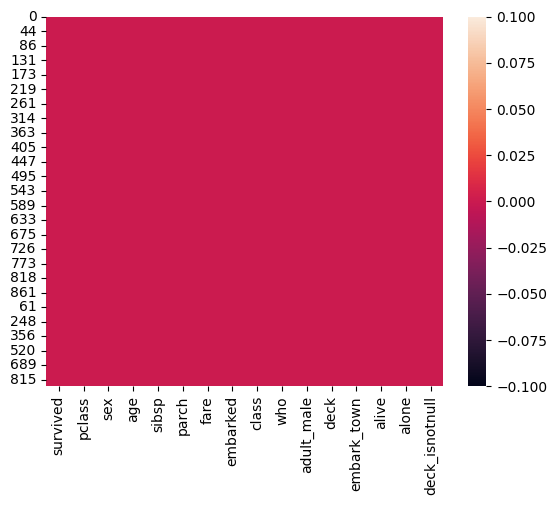

In [247]:
sns.heatmap(df.isnull())

모든 결측치가 잘 제거되었음을 확인할 수 있음

# Encoding

In [238]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 889
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   survived        891 non-null    int64  
 1   pclass          891 non-null    int64  
 2   sex             891 non-null    int64  
 3   age             891 non-null    float64
 4   sibsp           891 non-null    int64  
 5   parch           891 non-null    int64  
 6   fare            891 non-null    float64
 7   embarked        891 non-null    object 
 8   class           891 non-null    object 
 9   who             891 non-null    object 
 10  adult_male      891 non-null    int64  
 11  deck            891 non-null    object 
 12  embark_town     891 non-null    object 
 13  alive           891 non-null    int64  
 14  alone           891 non-null    int64  
 15  deck_isnotnull  891 non-null    int64  
dtypes: float64(2), int64(9), object(5)
memory usage: 118.3+ KB


In [248]:
#binary categorical
df['sex']= df.sex.replace({"female":1, "male":0})
df['adult_male']= df.adult_male.replace({True:1, False:0})
df['alone']= df.alone.replace({True:1, False:0})
df['alive']= df.alive.replace({"yes":1, "no":0})

In [249]:
# 정규화, 인코딩
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [250]:
#class는 숫자이므로 따로 mapping
df['class']= df['class'].replace({'Third':3, 'Second':2, 'First':1})

In [252]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 889
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   survived        891 non-null    int64   
 1   pclass          891 non-null    int64   
 2   sex             891 non-null    int64   
 3   age             891 non-null    float64 
 4   sibsp           891 non-null    int64   
 5   parch           891 non-null    int64   
 6   fare            891 non-null    float64 
 7   embarked        891 non-null    object  
 8   class           891 non-null    category
 9   who             891 non-null    object  
 10  adult_male      891 non-null    int64   
 11  deck            891 non-null    object  
 12  embark_town     891 non-null    object  
 13  alive           891 non-null    int64   
 14  alone           891 non-null    int64   
 15  deck_isnotnull  891 non-null    int64   
dtypes: category(1), float64(2), int64(9), object(4)
memory usage: 

In [253]:
# multiclass categorical
mul_cat = ['embarked', 'deck'	,'embark_town', 'who']
onehot_encoder = OneHotEncoder(sparse_output = False)
onehot = onehot_encoder.fit_transform(df[mul_cat])
col_names = onehot_encoder.get_feature_names_out(mul_cat)
onehot_df = pd.DataFrame(onehot, columns = col_names)

In [255]:
temp = df.drop(mul_cat, axis =1)

In [257]:
df_pro =pd.concat([temp, onehot_df], axis = 1)

In [258]:
#전처리 완료된 데이터셋
df_pro.head(5)

,survived,pclass,sex,age,sibsp,parch,fare,class,adult_male,alive,...,deck_E,deck_F,deck_G,deck_Unkown,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,who_child,who_man,who_woman
0,0,3,0,22.000000,1,0,7.2500,3,1,0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1,3,1,26.000000,0,0,7.9250,3,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0,3,0,35.000000,0,0,8.0500,3,1,0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
5,0,3,0,29.699118,0,0,8.4583,3,1,0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
7,0,3,0,2.000000,3,1,21.0750,3,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [259]:
X = df_pro.drop(["survived"], axis= 1)
y = df_pro[["survived"]]

In [261]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X,y,  test_size = 0.8, random_state=42)

In [262]:
# standard scaling continuous
continuous = ['age', 'fare']
scaler = StandardScaler()

In [263]:
X_train[continuous]= scaler.fit_transform(X_train[continuous])
X_test[continuous] = scaler.transform(X_test[continuous])

<Axes: xlabel='age', ylabel='Count'>

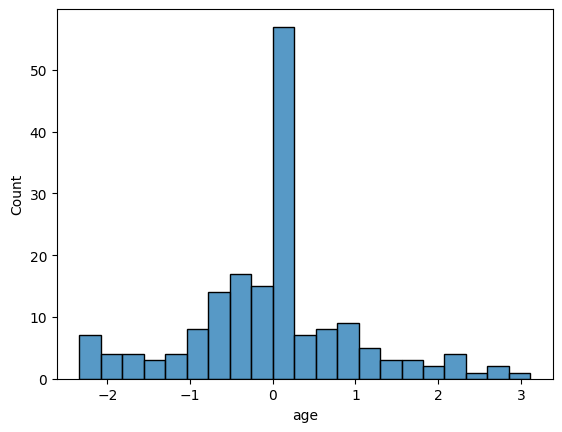

In [264]:
sns.histplot(X_train.age)

<Axes: xlabel='fare', ylabel='Count'>

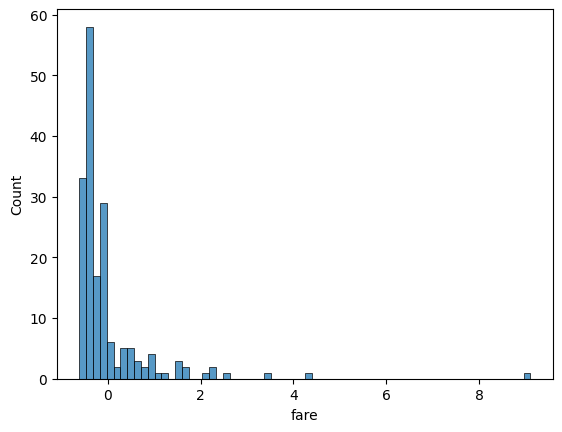

In [265]:
sns.histplot(X_train.fare)

In [279]:
X_train =X_train.astype({"class":"int"})
X_test =X_test.astype({"class":"int"})

# 모델링

In [ ]:
# !pip install scikit-optimize
# !pip install catboost

In [270]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Categorical, Real, Integer

In [267]:
logistic = LogisticRegression()
rf= RandomForestClassifier()
lgbm =LGBMClassifier()
catboost =CatBoostClassifier()
xgb = XGBClassifier()

In [ ]:
## 앙상블 학습
np.random.seed(0)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score as acc

lr = LogisticRegression()
rf = RandomForestClassifier()
ab = AdaBoostClassifier()
gb = GradientBoostingClassifier()
estimators = [('LR', lr), ('RF', rf), ('AB', ab), ('GB', gb)]

voting = VotingClassifier(estimators, voting = 'hard')
voting.fit(X_train, y_train)
y_voting = voting.predict(X_test)

print(acc(y_test, y_voting))

In [280]:

# 모델과 하이퍼파라미터 그리드 설정
models = {
    'LightGBM': (LGBMClassifier(),
                 {
                     'num_leaves': Integer(2, 50),
                     'learning_rate': Real(0.01, 1.0, 'log-uniform'),
                     'n_estimators': Integer(50, 500),
                     'max_depth': Integer(2, 20),
                     'subsample': Real(0.1, 1.0, 'uniform'),
                     'min_child_samples': Integer(5, 100),
                 }),
    'CatBoost': (CatBoostClassifier(verbose=False),
                 {
                     'depth': Integer(2, 10),
                     'learning_rate': Real(0.01, 1.0, 'log-uniform'),
                     'n_estimators': Integer(50, 500),
                     'subsample': Real(0.1, 1.0, 'uniform'),
                     'colsample_bylevel': Real(0.1, 1.0, 'uniform'),
                 }),
    'Logistic Regression': (LogisticRegression(),
                            {
                                'C': Real(0.01, 10.0, 'log-uniform'),
                                'penalty': ['l1', 'l2'],
                                'solver': ['liblinear'],
                                'max_iter': Integer(50, 500),
                            })
}

model_results = []

# 모델별로 튜닝 및 적합
for model_name, (model, param_grid) in models.items():
    print(f"Training {model_name}...")

    # BayesSearchCV를 사용한 튜닝
    bayes_search = BayesSearchCV(model, param_grid, scoring='accuracy',
                                 n_iter=20, n_jobs=-1, random_state=42)
    bayes_search.fit(X_train, y_train)

    # 최적의 모델과 하이퍼파라미터 출력
    best_model = bayes_search.best_estimator_
    best_params = bayes_search.best_params_
    print(f"Best Parameters: {best_params}")

    # 테스트 데이터에 대한 예측 및 평가
    y_pred = best_model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    c_m = confusion_matrix(y_test, y_pred)
    print(f"F1 score: {f1}\n")
    print(f"Accuracy: {accuracy}\n")
    print(f"Confusion Matrix: {c_m}\n")


    # 모델 이름과 accuracy 결과 저장
    model_results.append((model_name, accuracy))

Training LightGBM...
[LightGBM] [Info] Number of positive: 69, number of negative: 109
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 121
[LightGBM] [Info] Number of data points in the train set: 178, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.387640 -> initscore=-0.457241
[LightGBM] [Info] Start training from score -0.457241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

KeyboardInterrupt: ignored

In [ ]:
model_results

[('Logistic Regression', 0.8075842696629213),
 ('RandomForest', 0.800561797752809),
 ('LightGBM', 0.8202247191011236),
 ('Catboost', 0.7907303370786517)]

accuracy가 가장 높은 LGBM 모델 선정

In [ ]:
model_results[2] #최종 스코어

('LightGBM', 0.8202247191011236)